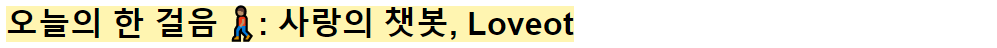

## Contexts

### 1. READY
    1-1 오늘의 Exp와 Rubric  
    1-2 사용하는 라이브러리  

### 2. GAME
    2-1. 데이터 읽어오기  
    2-2. 데이터 전처리  
        -1. 데이터 가공
        -2. 토크나이저 설정
        -3. max_length 설정
        -4. Train set Split
        
    2-3. 모델 학습  
        -1. 관련 함수 생성 (Multi-head Attention, masking)
        -2. 인코더 생성
        -3. 디코더 생성
        -4. 트랜스포머 구현
        -5. 최적화, 손실함수 선정
        
    2-4. 데이터 평가   

### 3. POTG (best Play Of The Game)
    3-1. 소감(POTG)  
    3-2. 어려웠던 점과 극복방안  
    3-3. 추후  

---


# 1. Ready
## 1-1. 오늘의 Exp와 Rubric


오늘은 git 의 송영숙님이 제공해주시는 한국어 문답 set 을 이용해  
위로봇 Loveot (Love + bot ; 사랑의 말로 위로해주는 봇) 을 만든다.

이 분은 깃허브에서 챗봇 트레이닝용 문답 데이터 11,867개를 제공해준다.  
데이터는 다음 카페의 내용을 참고하여 직접 제작하셨다.

데이터의 대답 자체가 질문자의 감정을 헤아리고  
위로하는 문맥으로 이루어져 있기 때문에  

해당 자료를 바탕으로 학습된 챗봇도 위로와 사랑으로 가득 찬 대답을
하리라 예상된다.


[송영숙 님의 Git hub](https://github.com/songys/Chatbot_data)

오늘의 루브릭은 다음과 같다.

||평가문항|상세기준|
|---|---|---|
|1|한국어 전처리를 통해 학습 데이터셋을 구축하였다.|공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다.|
|2|트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다.|구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.|
|3|한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다.|한국어 입력문장에 그럴듯한 한국어로 답변을 리턴하였다.|


## 1-2. 사용하는 라이브러리

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds # Subword 토크나이저 라이브러리

import os #데이터 경로 라이브러리
import re # 정규표현식

import numpy as np
import pandas as pd #데이터 배열 처리 라이브러리

import matplotlib.pyplot as plt # 시각화 라이브러리

# 2. GAME
## 2-1. 데이터 읽어오기

In [6]:
dataset_filepath = os.getenv('HOME')+'/aiffel/workplace/E12/transformer_chatbot/data/ChatbotData .csv' 
df = pd.read_csv(dataset_filepath) 
df.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [16]:
df.tail()

,Q,A,label
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2
11822,힘들어서 결혼할까봐,도피성 결혼은 하지 않길 바라요.,2


In [9]:
df.columns

Index(['Q', 'A', 'label'], dtype='object')

데이터셋은 Q 질문, A 답변, 그리고 Label 0 으로 이루어져 있다.

In [15]:
df.isnull().values.any()

False

결측치는 없는 듯 하다.

## 2-2.데이터 전처리

### 2-2-1.  데이터 가공

In [58]:
def preprocess_sentence(sentence):
    sentence = sentence.strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "배고프다." => "배고프다 ."와 같이
  # 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)

  # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  # sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence) 영어의 경우
    sentence = re.sub(r"([a-zA-Z]+)", r" \1 ", sentence)
    sentence = re.sub(r"([ㅏ-ㅣ]+)", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

  # sentence = re.sub(r"^[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", " ", sentence) #제대로 된 한국어가 아닌 경우 ' ' 로 대체합니다
    sentence = sentence.strip()
    
    return sentence


1. 단어별로 구분할 수 있도록 특수문자와 영어 사이에 공백을 주었다.
2. ㅠㅠ, ㅡㅡ 같은 모음 이모티콘도 하나의 의미를 가진다 생각하여 지우지 않고 보존시켰다.


In [60]:
Q = list(map(preprocess_sentence, df['Q']))
A = list(map(preprocess_sentence, df['A']))

In [68]:
print(f'전체 샘플 수, 질문 : {len(Q)} , 대답 : {len(A)}\n\n')

cnt = 0
for a, b in zip(Q,A):
    print(f'질문 : {a}')
    print(f'대답 : {b}')
    print()
    cnt += 1
    if cnt > :
          break

전체 샘플 수, 질문 : 11823 , 대답 : 11823


질문 : 12시 땡 !
대답 : 하루가 또 가네요 .

질문 : 1지망 학교 떨어졌어
대답 : 위로해 드립니다 .

질문 : 3박4일 놀러가고 싶다
대답 : 여행은 언제나 좋죠 .

질문 : 3박4일 정도 놀러가고 싶다
대답 : 여행은 언제나 좋죠 .

질문 : PPL 심하네
대답 : 눈살이 찌푸려지죠 .

질문 : SD 카드 망가졌어
대답 : 다시 새로 사는 게 마음 편해요 .



### 2-2-2. 데이터 토크나이저 설정

In [79]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(Q + A, target_vocab_size=2**13)
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성

단어사전은 Tensor 에서 지원하는 `SubwordText` 를 이용하여 만들었다.


In [70]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

tokenizer.vocab_size

8173

In [71]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8173]
END_TOKEN의 번호 : [8174]


In [72]:
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8175


만들어진 단어사전에

Start 토큰과 End 토큰을 추가히기 위해 준비했다.

In [82]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환

print(f'질문 : {Q[1]}')
print(f'대답 : {A[1]}\n')
    
print('정수 인코딩 후의 첫번째 질문 샘플: {}'.format(tokenizer.encode(Q[1])))
print('정수 인코딩 후의 첫번째 답변 샘플: {}'.format(tokenizer.encode(A[1])))

질문 : 1지망 학교 떨어졌어
대답 : 위로해 드립니다 .

정수 인코딩 후의 첫번째 질문 샘플: [7966, 47, 917, 7949, 997, 1716]
정수 인코딩 후의 첫번째 답변 샘플: [1829, 5502, 1]


위와 같이 숫자 데이터로 변환되었음을 확인할 수 있다.  
다만 Subword 의 토크나이저가 단순히 단어별로 끊어 학습한 것은 아닌걸로 보인다.

### 2-2-3. max_length 설정 및 토크나이저 입력

문장 길이를 일정하게 맞춰주기 위해선,  
해당 문장들의 평균 길이와 표준편차를 구해서  

(평균 + 2 * 표준편차)

총 데이터의 96% 정도를 담는 길이를 구했다.


In [147]:

total_data_text = Q + A

total_data_text = [tokenizer.encode(text) for text in total_data_text]

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  5.661042036708111
문장길이 최대 :  29
문장길이 표준편차 :  2.563976726194329
pad_sequences maxlen :  10
전체 문장의 0.9524655332825848%가 maxlen 설정값 이내에 포함됩니다. 


In [96]:
MAX_LENGTH = 12 #start end 토큰 포함

In [97]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 28 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
    # 최대 길이 28으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
    return tokenized_inputs, tokenized_outputs

In [98]:
questions, answers = tokenize_and_filter(Q,A)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8175
필터링 후의 질문 샘플 개수: 10735
필터링 후의 답변 샘플 개수: 10735


초기 데이터에서 약 1000개의 데이터가 정제되었음을 확인할 수 있다.

### 2-2-4. Train , Test split

만들어진 자료를 <start> <end> 로 각각 분리해 input과 label(정답) 데이터로 나눴다.

In [99]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## 2-3.모델 학습

우리는 트렌스포머 모델로 학습 시킨다.

transformer 는 encoder 와 decoder 두 개의 모델로 이루어진
seq2seq 모델로서

incoder 를 통해 context 벡터값, 즉 문맥 정보를 저장한 후

decoder 에 들어온 input 과 context 값을 참고해 결과값을 도출한다.


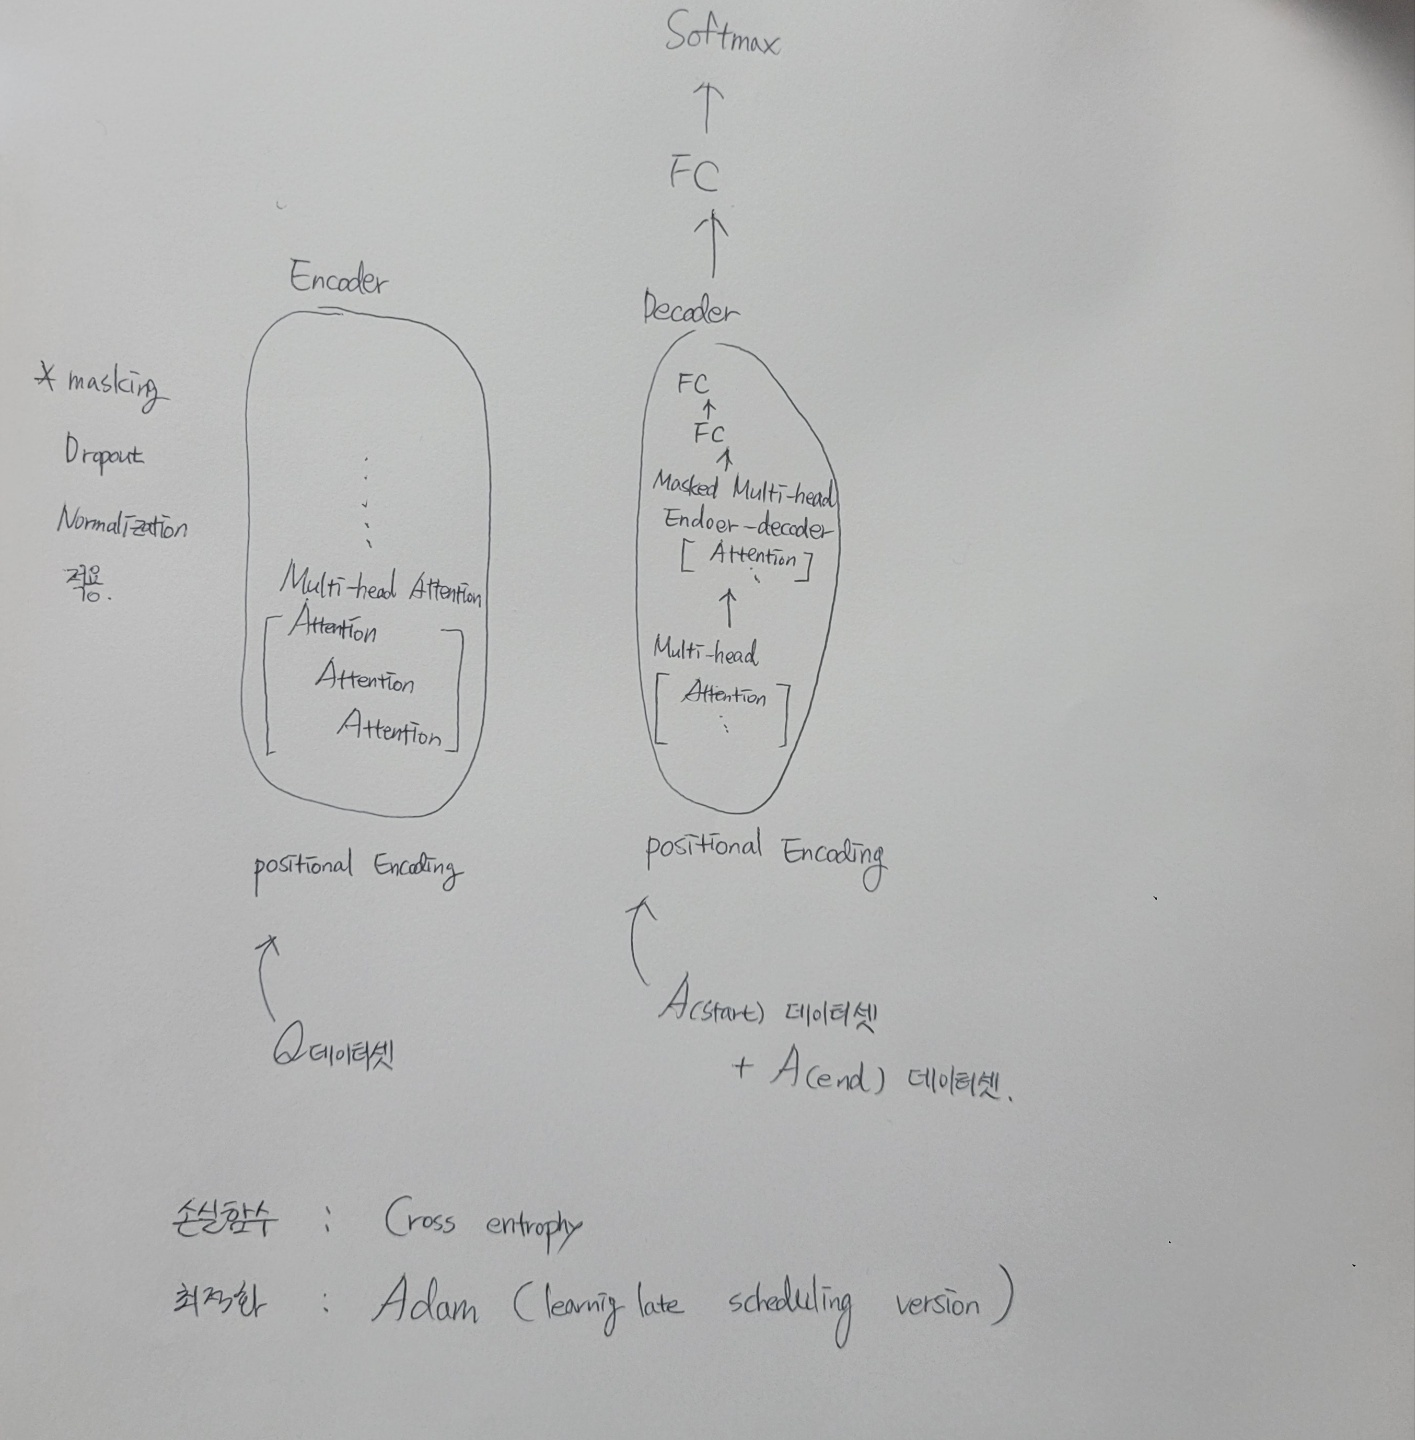

모델에 대한 요약이다.

1. Q 데이터셋을 encoding 하여 context 데이터 값 생성,
2. A 데이터셋을 context 값과 함께 decoding 하여 후에 나올 말 예측
3. 관련 손실함수 및 최적화함수 사용, 곳곳에 필요한 normalize, masking, Dropout 진행

### 2-3-1. 필요한 함수 생성

#### 1. Positional encoding layer

In [100]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
    # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


#### 2. scaled dot product 

In [101]:
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

      # softmax적용
        attention_weights = tf.nn.softmax(logits, axis=-1)

      # 최종 어텐션은 가중치와 V의 닷 프로덕트
        output = tf.matmul(attention_weights, value)
    return output

#### 3. Multi-head Attention

In [102]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs


#### 4. padding masking

In [103]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

#### 5. Lock-ahead masking

In [104]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)


### 2-3-2. 인코딩 생성


In [105]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
        inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

      # 패딩 마스크 사용
        padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

      # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
        attention = MultiHeadAttention(
          d_model, num_heads, name="attention")({
              'query': inputs,
              'key': inputs,
              'value': inputs,
              'mask': padding_mask
          })

      # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
        attention = tf.keras.layers.Dropout(rate=dropout)(attention)
        attention = tf.keras.layers.LayerNormalization(
          epsilon=1e-6)(inputs + attention)

      # 두 번째 서브 레이어 : 2개의 완전연결층
        outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
        outputs = tf.keras.layers.Dense(units=d_model)(outputs)

      # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
        outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
        outputs = tf.keras.layers.LayerNormalization(
          epsilon=1e-6)(attention + outputs)

        return tf.keras.Model(
          inputs=[inputs, padding_mask], outputs=outputs, name=name)


In [106]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
    inputs=[inputs, padding_mask], outputs=outputs, name=name)


### 2-3-3 디코더 생성

In [107]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
        })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
        })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)


In [108]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
          units=units,
          d_model=d_model,
          num_heads=num_heads,
          dropout=dropout,
          name='decoder_layer_{}'.format(i),
      )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)


### 2-3-4. 트랜스포머 생성

In [109]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크

    enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
    enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

  # 디코더
    dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)


#### 하이퍼 파라미터 설정

In [110]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기, 노드
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3147008     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### 2-3-5. 손실함수 , 최적화 함수

In [111]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32) #패딩마스크
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [113]:


class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


In [114]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])


In [115]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
168/168 [==============================] - 19s 30ms/step - loss: 4.8568 - accuracy: 0.0884
Epoch 2/20
168/168 [==============================] - 5s 30ms/step - loss: 3.9917 - accuracy: 0.1739
Epoch 3/20
168/168 [==============================] - 5s 30ms/step - loss: 3.3254 - accuracy: 0.1776
Epoch 4/20
168/168 [==============================] - 5s 30ms/step - loss: 3.0442 - accuracy: 0.1865
Epoch 5/20
168/168 [==============================] - 5s 30ms/step - loss: 2.8607 - accuracy: 0.1979
Epoch 6/20
168/168 [==============================] - 5s 30ms/step - loss: 2.6782 - accuracy: 0.2092
Epoch 7/20
168/168 [==============================] - 5s 30ms/step - loss: 2.4791 - accuracy: 0.2274
Epoch 8/20
168/168 [==============================] - 5s 30ms/step - loss: 2.2590 - accuracy: 0.2513
Epoch 9/20
168/168 [==============================] - 5s 30ms/step - loss: 2.0188 - accuracy: 0.2784
Epoch 10/20
168/168 [==============================] - 5s 30ms/step - loss: 1.7598 - accur

## 2-4.데이터 평가

새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.

입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.

패딩 마스킹과 룩 어헤드 마스킹을 계산한다.

디코더는 입력 시퀀스로부터 다음 단어를 예측한다.

디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.

END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

In [116]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)


In [117]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence 

In [118]:
sentence_generation('나 너무 힘들어')

입력 : 나 너무 힘들어
출력 : 많이 힘들었죠 .


'많이 힘들었죠 .'

In [121]:
sentence_generation('아이펠 열심히 따라가고 있어')

입력 : 아이펠 열심히 따라가고 있어
출력 : 열심히 하네요 .


'열심히 하네요 .'

In [144]:
sentence_generation('세상은 악으로 가득 차있어')

입력 : 세상은 악으로 가득 차있어
출력 : 혼자하는 것도 익숙해질 거예요 .


'혼자하는 것도 익숙해질 거예요 .'

In [145]:
sentence_generation('내 친구들은 정상인가요?')

입력 : 내 친구들은 정상인가요?
출력 : 많이 힘들었죠 .


'많이 힘들었죠 .'

이정도면 그래도 마음이 따뜻해졌다,  
자식,,, 사랑한다

# 3. POTG
## 3-1. 소감

#### "🖐 이제는 우리가 헤어져야 할시간, 다음에 또 만나요?"
방대한 트랜스포머 구조를 이해하느라 너무 많은 시간이 걸렸습니다.  
이젠 머리를 식히고 복습을 준비할 때입니다.  

복잡한 만큼 구조의 특이점과 특징이 두드러지고 그래서 성능도 훌륭합니다.  
하나 하나 차분히 보시면 transformer 에는 두 쌍의 데이터셋이 필요하고,  
그것이 seq2seq 모델의 핵심임을 알 수 있습니다.

## 3-2. 어려웠던 점과 극복방안

### -1. 정규표현식의 한글 전처리

정규표현식을 사용하느라 진땀 뺐는데, 내가 하고 싶은 건 다음과 같았다.

'너무 힘들어요ㅠㅠ' -> '너무 힘들어요 ㅠㅠ"
"SD  카드" -> "SD 카드"

정규 표현식 함수를 써주는 순서도 달리 해야 했다.

우선 `[ㅏ-ㅣ]+` 를 `\1 ` 로 공백을 줄 수 있었고
`[' ']+` 를 `' '` 로 바꾸는 메서드를 가장 나중으로 미뤘다.

다행히도 모두 해결했다!

### -2. 토크나이저 인코딩 후 이상한 점

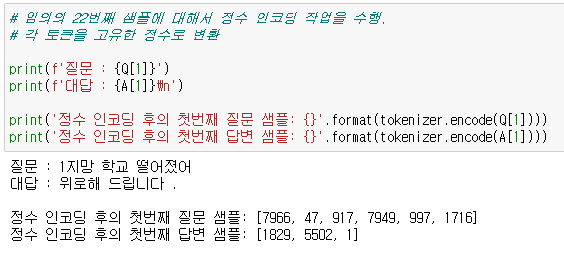

질문이 '1지망 학교 떨어졌어' 이면 3개의 정수가 나와야 하는 것 아닌가?

속이 보이지 않는  
` tfds.deprecated.text.SubwordTextEncoder.build_from_corpus` 메서드가  
어떤 식으로 토큰화를 시켰는지 알 수 없기에 나오는 의문이다.

그래서 일정량의 텍스트 데이터를 끌어 와 
숫자가 어느 텍스트와 매치되는지 살펴보았다.


In [143]:
for i in range(7):
    tokenized_string = tokenizer.encode(Q[i])
    print (f'원래 문장 : {Q[i]}')

    cnt = 0

    for ts in tokenized_string:
        print (f'{tokenized_string[cnt]} ----> {tokenizer.decode([ts])}')
        cnt += 1
    print()

원래 문장 : 12시 땡 !
7912 ----> 12
4207 ----> 시 
3060 ----> 땡
42 ---->  !

원래 문장 : 1지망 학교 떨어졌어
7966 ----> 1
47 ----> 지
917 ----> 망
7949 ---->  
997 ----> 학교 
1716 ----> 떨어졌어

원래 문장 : 3박4일 놀러가고 싶다
7968 ----> 3
1434 ----> 박
4652 ----> 4일
7949 ---->  
3651 ----> 놀러가고 
67 ----> 싶다

원래 문장 : 3박4일 정도 놀러가고 싶다
7968 ----> 3
1434 ----> 박
4652 ----> 4일
7949 ---->  
1293 ----> 정도 
3651 ----> 놀러가고 
67 ----> 싶다

원래 문장 : PPL 심하네
7997 ----> P
7997 ----> P
7993 ----> L
7949 ---->  
4190 ----> 심하네

원래 문장 : SD 카드 망가졌어
8000 ----> S
7985 ----> D
7949 ---->  
2191 ----> 카드 
917 ----> 망
78 ----> 가
819 ----> 졌어

원래 문장 : SD 카드 안돼
8000 ----> S
7985 ----> D
7949 ---->  
2191 ----> 카드 
200 ----> 안돼



데이터 분석을 통해 알게 된 점.

1. 다수의 공백은 하나로만 처리해 주었다.
2. 영어 철자는 한글자씩 처리해 주었다.
3. 숫자와 함께 쓰인 글자는 한글자로 처리된다.

때문에 subword 의 문장분석이 아직 완벽하지는 않다는 것을 알았다.   
현재는 트랜스포머에 사용되는 한국어 전용 pre-trained data Kor-bert 까지 있다고 한다.

### -3. max_length 설정 시 유의점

초반에는 길이를 설정해주기 위해 단순히
question 과 Answer 데이터만 담아 길이를 측정했더니  
평균길이가 14인 것으로 나타났다.

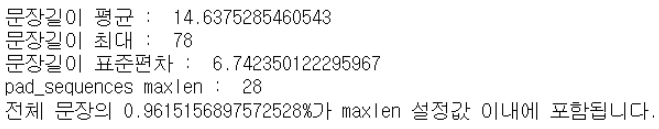

이것의 이유는 토크나이즈 화 되지 않은 한글 데이터를 통해 나누었기 때문이다.  
토큰 화 되지 않은 상태는 공백 포함 최대 78 길이의 데이터까지 존재했다.  
때문에 모든 데이터를 토큰화 시킨 숫자데이터로 다시 데이터를 만들어  
길이를 조정했다

그 코드는 다음과 같다.

`total_data_text = [tokenizer.encode(text) for text in total_data_text]`

결과적으로 나온 max_len 길이는 10이며, 그 결과는 다음과 같다.

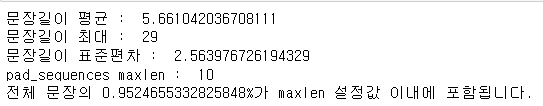

확연한 차이를 볼 수 있다.

### -4. transfomer 모델의 복잡도

다양한 함수와 코드, 수 개의 layer 가 들어가는 encoder, decoder 들의 묶음으로 이루어진 트랜스포머,  
한번에 이해하기엔 너무 거대하고 방대한 모델이다.

그림에서 이해하기 어려운 부분이 많았는데, 공부하면서 하나 알게 된 점은  
마스크에 대해서이다.

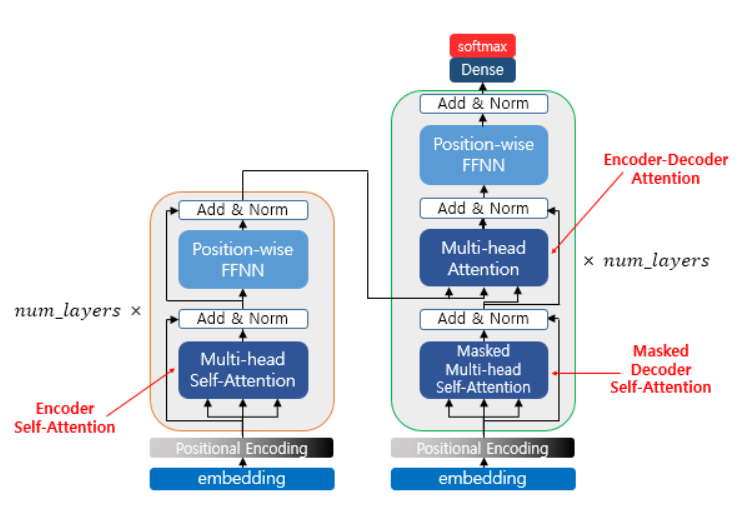

마스크는 패딩 값을 가려주는 패딩마스크와  
결과값을 찾아내기 위한 Lock-ahead 마스크가 있다.  

근데 이 사진에서는 Masked 라고 해서  
decoder self-attention 에만 표시가 되어있고  
또 어떤 마스크인지 알 수가 없었는데, 

코드 분석을 통해 저기서 이루어진 마스크는
Lock-ahead Mask 이고, 

padding Mask 는 임베딩 레이어 이전에 한번,  
다음 인코더로 넘어갈 때 한 번씩 수행되어 들어감을 알았다.

결과적으로 하나의 커다란 transformer 가 생성되는 것으로,

내가 이해한대로 그림을 그려 보았다.

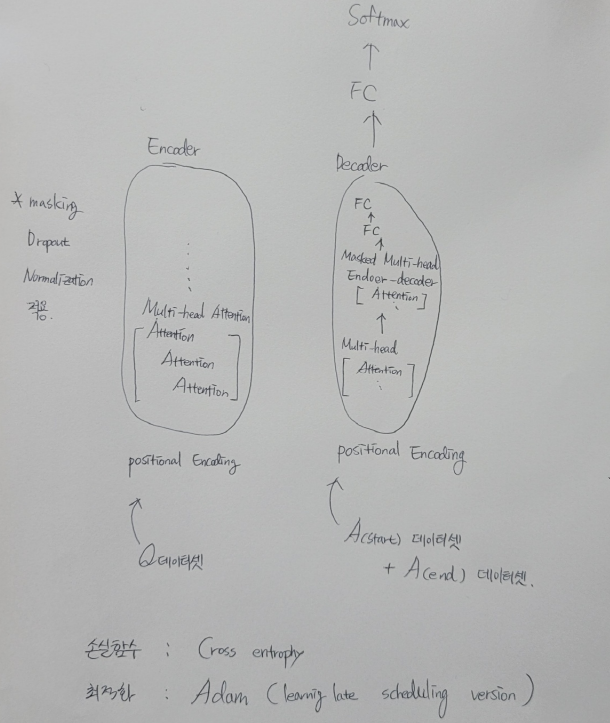

아직 의문인 부분은 많다.

1. 왜 Adam 을 사용하면서 learning_late 의 값에 변동을 주는 custom Scheduling을 사용하는지?
2. Attention 에서 Q 와 K 를 내적한 후 V 를 곱한 Attention Value 가 무엇을 의미하는지?
3. decoder 에서 어떻게 contexts 값을 이용하는지?

허나 전체적인 흐름에 대해서는 감을 잡을 수 있었다.
encoder 에 들어가는 것은 Q(질문) 에 대한 데이터셋, 그리고 그의 맥락을 도출  
decoder 에선 A(대답) 에 대한 데이터셋, 그리고 그것을 예측한다.



## 3-3. 추후

현재 NLP 분야의 최신 기술이라고 일컬어지는   
트랜스포머, 그 트랜스포머를 잘 이용하기 위해선

pre-trained 데이터 Bert 의 이해가 필요하다.  
특히 한국어를 다루는 kor-bert 가 나왔다고 하니  
좀 더 알아보고 싶다.